In [1]:
# DIRECTORY SET
import os
import sys
from pathlib import Path
base_dir=Path(os.getcwd()).parent
# os.chdir(os.path.join(base_dir, 'serverproject'))
os.chdir(base_dir)
print(os.getcwd())

# Load dotenv
import dotenv
dotenv.load_dotenv()

# DJANGO SETUP
import django
sys.path.append(os.path.abspath(''))
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "serverproject.settings")
django.setup()

# Import async modules
import asyncio
from asgiref.sync import sync_to_async

# Import display modules
from IPython.display import display, Markdown

# Import other modules
import faiss

# import reloading
from importlib import reload

d:\DestinyFolder\DestinyRecaps\DestinyRecapsApi\serverproject


In [2]:
%load_ext autoreload
%autoreload 2

from destinyapp.models import StreamRecapData, FastRecapData

from core import services
from core import utils
from core import controller

# Fetch Underlying Data

In [3]:
video_id="9KENE2wOphQ_no_recap"
data_grabbber=await sync_to_async(FastRecapData.objects.filter)(video_id=video_id)
fast_recap_data=await sync_to_async(data_grabbber.first)()

In [4]:
async def fetch_embedding(chunk):
    model="text-embedding-3-large"
    fails=0
    while fails<5:
        try:
            return await utils.async_openai_client.embeddings.create(input=chunk, model=model)
        except Exception as e:
            fails+=1
            print("Emedding Fail Retrying:",e)
            await asyncio.sleep(10+(fails*2))
    return None


# Make Embeddings

In [44]:
# RECAPS
all_embedding_responses=[]
tasks=[]
for segment in fast_recap_data.plot_object["segments"]:
    tasks.append(fetch_embedding(segment["recap"]))
all_embedding_responses=await asyncio.gather(*tasks)
all_embeddings=[response.data[0].embedding for response in all_embedding_responses]

# # ANNOTATIONS
# all_embedding_responses=[]
# tasks=[]
# for segment in fast_recap_data.plot_object["segments"]:
#     annotations_str=" ".join(segment["annotations"])
#     tasks.append(fetch_embedding(annotations_str))
# all_embedding_responses=await asyncio.gather(*tasks)
# all_embeddings=[response.data[0].embedding for response in all_embedding_responses]


# # RAW TEXT
# all_embedding_responses=[]
# tasks=[]
# for segment in fast_recap_data.plot_object["segments"]:
#     annotations_str=" ".join(segment["texts"])
#     tasks.append(fetch_embedding(annotations_str))
# all_embedding_responses=await asyncio.gather(*tasks)
# all_embeddings=[response.data[0].embedding for response in all_embedding_responses]

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

In [31]:
def value_labels(cluster_labels, k=5):
    prev_v=None
    count=0
    for i in range(len(cluster_labels)):
        if prev_v!=cluster_labels[i]:
            count+=1
        prev_v=cluster_labels[i]

    return count/(k**0.25)

In [45]:
def cluster_generate(all_embeddings, k, filter_window=5):
    embeddings_array = np.array(all_embeddings)

    # Calculate the pairwise distances between the embeddings
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(embeddings_array)

    cluster_labels2=cluster_labels.copy()

    if filter_window>1:
        last_x_clusters=[None]*(5-int(filter_window/2))+list(cluster_labels2[:int(filter_window/2)])
        # last_x_clusters=[None]*filter_window
        for i in range(len(cluster_labels)):
            # get the number in last_3_clusters that dominates, in otherwards get the item with the max quantity
            last_x_clusters.pop(0)
            last_x_clusters.append(cluster_labels[i+int(filter_window/2)] if len(cluster_labels) > (i+int(filter_window/2)) else None)
            max_quantity_item=max(set(last_x_clusters), key=last_x_clusters.count)
            if max_quantity_item:
                cluster_labels2[i]=max_quantity_item
        cluster_labels=cluster_labels2
    return cluster_labels

In [46]:
lowest_k=None
lowest_value=None
filter_window=3
for k in range(4,7):
    cluster_labels=cluster_generate(all_embeddings, k, filter_window)

    cluster_value=value_labels(cluster_labels, k)
    print("K: ",k, cluster_value)
    if lowest_value is None or cluster_value<lowest_value:
        lowest_value=cluster_value
        lowest_k=k

print("Lowest K:",lowest_k, "Lowest Value:",lowest_value)
k=lowest_k
cluster_labels=cluster_generate(all_embeddings, k, filter_window)

K:  4 24.74873734152916
K:  5 25.41213158910404
K:  6 31.30821210806735
Lowest K: 4 Lowest Value: 24.74873734152916


# Plot if desired

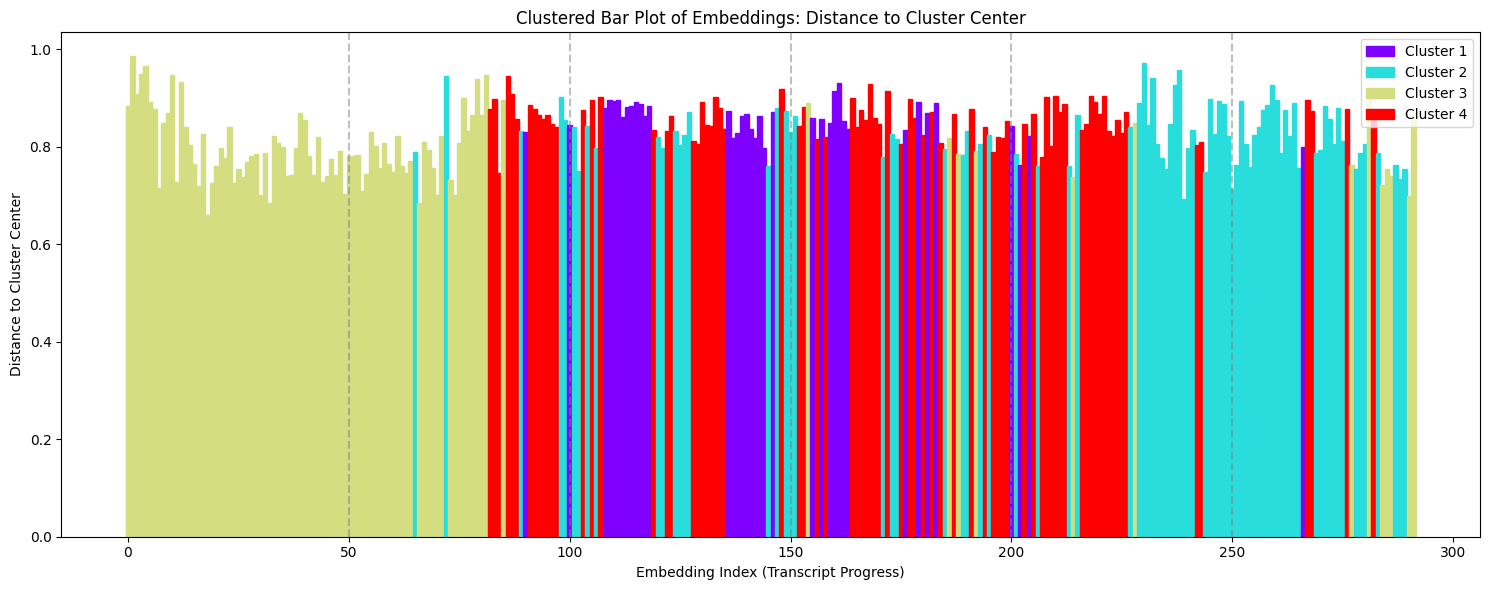

In [47]:
# 2. Calculate distances from each embedding to its cluster center
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(all_embeddings)
distances_to_center = pairwise_distances(all_embeddings, kmeans.cluster_centers_[cluster_labels])
distances_to_center = distances_to_center[np.arange(len(all_embeddings)), 0]

# 3. Create the bar plot
plt.figure(figsize=(15, 6))
bars = plt.bar(range(len(distances_to_center)), distances_to_center, width=1.0)

# 4. Color the bars according to their cluster
colors = plt.cm.rainbow(np.linspace(0, 1, k))
for i, bar in enumerate(bars):
    bar.set_color(colors[cluster_labels[i]])

# 5. Customize the plot
plt.xlabel('Embedding Index (Transcript Progress)')
plt.ylabel('Distance to Cluster Center')
plt.title('Clustered Bar Plot of Embeddings: Distance to Cluster Center')

# Add a color legend
handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(k)]
plt.legend(handles, [f'Cluster {i+1}' for i in range(k)])

# 6. Add vertical lines to separate every 50 bars (adjust as needed)
for i in range(50, len(distances_to_center), 50):
    plt.axvline(x=i, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [52]:
cluster_labels[225:240]

array([3, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [54]:
fast_recap_data.plot_object["segments"][224]

{'category': 'Judicial Philosophy Discussion',
 'color': 'gray',
 'start_time': 14965720,
 'end_time': 15023159,
 'width': 0.0030603970060441763,
 'x': 0.7973730158222723,
 'texts': ["ndobs that that's what uh you knowwhatever lact toid is caring about he'scaring about having conservativeconservatives from the federal societythat he agrees with that's what is atplay not like number of seats yeahoriginalist that's original yeahoriginalism is a Judicial philosophyit's different political conservatismthat's an important distinction but Ibut but I want but I want to ask you Iwant to ask you a question um when youwere going with that back and forth withWick you brought up a non-court packingyou know remedy now I already was clearthat I I still oppose that but myquestion for you is why didn't you comein your hot proposing that remedy asopposed to the much more incendiaryCourt packing oh I I'm happy to do bothI'm indifferent between them hold on soso if we do the non-court packing remedythen 

In [56]:
fast_recap_data.plot_object["segments"][241]

{'category': 'Norms in Politics',
 'color': 'gray',
 'start_time': 15858680,
 'end_time': 15908800,
 'width': 0.002670434686239909,
 'x': 0.8447556754729205,
 'texts': ["imspecifying that he's creating this normand then Ren rening on it immediatelyafterwards he didn't create a norm itwas a convers it was a suggestion it wasan AR he didn't create thenorm no but he argued no Joe Bidenargued for like an establishment of anorm in 1992 you understand that you canargue for the establishment of norm andstill follow the other Norms right youcan argue that right like I could arguewith a significant other that we shouldgo at the Outback house every Friday andwe might not do that I didn't create thenorm because I argued for it lact toidlact toid maybe maybe we could shortcutthis you acknowledge that McConnellactually doing it is substantively worsethan Biden talking about it youacknowledge that the McConnell actuallydoing it is wor no I don't want no it'snot worse it's a different thing it's anat

In [53]:
fast_recap_data.plot_object["segments"][228]

{'category': 'Accusations of Dishonesty',
 'color': 'gray',
 'start_time': 15196319,
 'end_time': 15243920,
 'width': 0.002536220301271067,
 'x': 0.8093974312251179,
 'texts': ["ressure youreforms the court packing those arepressure on the Supreme Court GibGibb resp I just want say one finalthing to Gibbs Gibbs uh do you prefervenmo or like PayPal how much likewhat's the preferred platform for me topay you for making our points for usbecause every time you speak you showwhat's really going on here what'sreally going on between you and me I'mactually honest I'm sitting here sayingI'm not even saying it's part I'msitting here saying hey this is what'shappened you got outplayed you're cryingyou can sit here and say that's SP I'mnot going to be one of these dishonestpeople like you are and try to lie topeople in order to get my way andaccomplish it and dress it up in windowdressing like a like a Christmas turkeybut that's what you're doing Papa you'resitting here lying to people you'resitt

# def clusters

In [12]:
async def def_cluster(segments, cluster_labels, cluster_id):
    cluster_text_data=""
    for i in range(len(segments)):
        seg=segments[i]  
        if cluster_labels[i]==cluster_id:
            cluster_text_data+=seg["recap"]+"\n"

    system_prompt="""You are to take a bunch of text summaries and pull them together into what the topic dicussed for that is. YOU MUST DESCRIBE IT IN A FEW WORDS AND THEN GIVE MORE CONTEXT BUT YOU ARE DISTILLING TO 1 CATEGORY OF TOPIC.
    
    When saying the topic do it in this format:
    
    **Topic: ...**
    ...
    
    Then give a brief description of the topic"""
    user_prompt=cluster_text_data
    prompt=[{"role":"system","content":system_prompt},{"role":"user","content":user_prompt}]
    topic_category_response, temp_cost=await utils.async_response_handler(prompt, utils.ModelNameEnum.gpt_4o_mini)

    topic_category=topic_category_response.split("**Topic:")[1].split("**")[0].strip()
    return topic_category, topic_category_response



In [60]:
tasks=[]
for i in range(k):
    tasks.append(def_cluster(fast_recap_data.plot_object["segments"], cluster_labels, i))

cluster_responses=await asyncio.gather(*tasks)

In [ ]:
for cluster_response in cluster_responses:
    print(cluster_response[0])

In [ ]:
fast_recap_data.plot_object["segments"]

In [25]:
cat_prompt=""
for i, seg in enumerate(fast_recap_data.plot_object["segments"]):
    cat_prompt+="Cluster: "+str(cluster_labels[i])+" "+seg["category"]+"\n"
    # cat_prompt+="".join(seg["annotations"])+"\n\n"
print(len(cat_prompt))

12277
12277


In [26]:
# Separate the clusters
cat_prompt=""
for j in range(k):
    for i, seg in enumerate(fast_recap_data.plot_object["segments"]):
        if cluster_labels[i]==j:
            cat_prompt+="Cluster: "+str(cluster_labels[i])+" "+seg["category"]+"\n"
    # cat_prompt+="".join(seg["annotations"])+"\n\n"
print(len(cat_prompt))

12277


In [29]:
cluster_labels[0]

2

In [28]:
fast_recap_data.plot_object["segments"][0]["category"]

'Casual Chat and Tech Discussion'

In [27]:
print(cat_prompt)

Cluster: 0 Political Ethics
Cluster: 0 Political Discussion
Cluster: 0 Historical Context of Judicial Decisions
Cluster: 0 Constitutional Checks and Balances
Cluster: 0 Constitutional Interpretation
Cluster: 0 Abortion Rights and Constitutional Interpretation
Cluster: 0 Constitutional Theory Discussion
Cluster: 0 Legal Analysis of Supreme Court Rulings
Cluster: 0 Supreme Court Procedures
Cluster: 0 Presidential Powers Discussion
Cluster: 0 Constitutional Law Discussion
Cluster: 0 Historical Legal Precedents
Cluster: 0 Presidential Immunity Discussion
Cluster: 0 Civil Liability Discussion
Cluster: 0 Presidential Accountability Discussion
Cluster: 0 Judicial Authority Discussion
Cluster: 0 Constitutional Law Discussion
Cluster: 0 Presidential Accountability Discussion
Cluster: 0 Presidential Powers Discussion
Cluster: 0 Immunity and Accountability Discussion
Cluster: 0 Historical Context Discussion
Cluster: 0 Political Reprisals Discussion
Cluster: 0 Criminal Justice Discussion
Cluster: 

In [19]:
system_prompt="""You will be given a bunch of segment summaries, these summaries are grouped into clusters. For each cluter number I want you to give a  4 word or less category for that cluster.

First identify how many clusters there are, for each cluster describe what it is about generally.
Once this is done annotate the category for each cluster number."""
user_prompt=cat_prompt
prompt=[{"role":"system","content":system_prompt},{"role":"user","content":user_prompt}]
topic_category_response, temp_cost=await utils.async_response_handler(prompt, utils.ModelNameEnum.gpt_4o_mini)

In [20]:
print(topic_category_response)

There are **3 clusters** identified in the provided summaries. Here’s a general description of each cluster:

1. **Cluster 1**: This cluster primarily focuses on political discussions, legal opinions, and critiques related to the judicial system, including topics like court packing, judicial nominations, and the dynamics of political power in relation to the judiciary.

2. **Cluster 2**: This cluster encompasses a wide range of discussions related to technology, politics, and personal experiences. It includes topics such as graphics card specifications, political ethics, public perception, and the impact of media on politics.

3. **Cluster 3**: This cluster is centered around constitutional discussions, legal analysis, and the implications of presidential powers. It includes topics like judicial authority, historical legal precedents, and the relationship between military authority and congressional power.

### Cluster Categories:
- **Cluster 1**: Judicial Politics
- **Cluster 2**: Tec

In [ ]:
print(cat_prompt)